# Choose Cluster

In [1]:
cluster_input = 13

# Quick Links

<ol>
    <li><a href=#prep_main_scores>Prepare GkmExplain, ISM, and deltaSVM Scores</a></li>
    <li><a href=#prep_conf_scores>Prepare Magnitude and Prominence Scores</a></li>
    <li><a href=#prep_score_df>Prepare Score DataFrames</a></li>
    <li><a href=#plot_score_distrib>Plot Score Distributions</a></li>
    <li><a href=#calculate_pvals>Calculate P-Values</a></li>
    <li><a href=#visualize_high_conf>Visualize High Confidence SNPs</a></li>
    <li><a href=#prep_final_table>Prepare Final SNPs Table</a></li>
</ol>

## Imports

In [2]:
# Basic

import sys
import math
import random
import statistics
from decimal import Decimal

# Data / ML / Stats Libraries

import numpy as np
import pandas as pd
import scipy
from scipy.stats import *
pd.set_option('display.max_columns', None)

# Visualization

from matplotlib import pyplot as plt
from plotnine import *
from viz_preprocess import *
from viz_sequence import *
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')

## Addresses

In [3]:
cluster = str(cluster_input)
clust_to_celltype = {1: 'excitatory_neurons', 2: 'inhibitory_neurons', 3: 'excitatory_neurons',
                     4: 'excitatory_neurons', 5: 'nigral_neurons', 6: 'nigral_neurons', 7: 'unknown_neurons',
                     8: 'opcs', 9: 'opcs', 10: 'opcs', 11: 'inhibitory_neurons',12: 'inhibitory_neurons',
                     13: 'astrocytes', 14: 'astrocytes', 15: 'astrocytes', 16: 'astrocytes', 17: 'astrocytes',
                     18: 'doublets', 19: 'oligodendrocytes', 20: 'oligodendrocytes', 21: 'oligodendrocytes',
                     22: 'oligodendrocytes', 23: 'oligodendrocytes', 24: 'microglia'}
celltype = clust_to_celltype[cluster_input]
observed_base = '/mnt/lab_data3/soumyak/adpd/'
observed_effect_fasta = observed_base + 'fasta_inputs/Cluster' + cluster + '.effect.fasta'
observed_noneffect_fasta = observed_base + 'fasta_inputs/Cluster' + cluster + '.noneffect.fasta'
null_base = '/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
additional_observed_base = '/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/additional_snps/'
additional_observed_effect_fasta = additional_observed_base + 'explain_inputs/Cluster' + cluster + '.effect.fasta'
additional_observed_noneffect_fasta = additional_observed_base + 'explain_inputs/Cluster' + cluster + '.noneffect.fasta'

## Get Input Sequences

In [4]:
observed_effect_seqs = [x.rstrip() for (i,x) in enumerate(open(observed_effect_fasta)) if i%2==1]
additional_observed_effect_seqs = [x.rstrip() for (i,x) in enumerate(open(additional_observed_effect_fasta)) if i%2==1]
all_observed_effect_seqs = observed_effect_seqs + additional_observed_effect_seqs
observed_effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in all_observed_effect_seqs]

print('Num Observed effect sequences:', '\t', '\t', len(observed_effect_onehot))

observed_noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(observed_noneffect_fasta)) if i%2==1]
additional_observed_noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(additional_observed_noneffect_fasta)) if i%2==1]
all_observed_noneffect_seqs = observed_noneffect_seqs + additional_observed_noneffect_seqs
observed_noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in all_observed_noneffect_seqs]

print('Num Observed noneffect sequences:', '\t', len(observed_noneffect_onehot))

Num Observed effect sequences: 	 	 305
Num Observed noneffect sequences: 	 305


# Prepare Observed GkmExplain, ISM, and deltaSVM Scores <a name='prep_main_scores' />

In [5]:
merged_observed_effect_scores = np.zeros(shape=(len(observed_effect_onehot), 1000, 4))
merged_observed_noneffect_scores = np.zeros(shape=(len(observed_noneffect_onehot), 1000, 4))
merged_observed_explain_scores = np.zeros(shape=(len(observed_effect_onehot),))

for fold in range(10):
    observed_effect_file = observed_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.effect.scores.txt'
    observed_effect_scores = get_hyp_scores(observed_effect_file, observed_effect_seqs)
    observed_effect_scores = np.array(observed_effect_scores)
    additional_observed_effect_file = additional_observed_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.effect.scores'
    additional_observed_effect_scores = get_hyp_scores(additional_observed_effect_file, additional_observed_effect_seqs)
    additional_observed_effect_scores = np.array(additional_observed_effect_scores)
    observed_effect_scores = np.concatenate((observed_effect_scores, additional_observed_effect_scores))
    merged_observed_effect_scores = merged_observed_effect_scores + observed_effect_scores
        
    observed_noneffect_file = observed_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.noneffect.scores.txt'
    observed_noneffect_scores = get_hyp_scores(observed_noneffect_file, observed_noneffect_seqs)
    observed_noneffect_scores = np.array(observed_noneffect_scores)
    additional_observed_noneffect_file = additional_observed_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.noneffect.scores'
    additional_observed_noneffect_scores = get_hyp_scores(additional_observed_noneffect_file, additional_observed_noneffect_seqs)
    additional_observed_noneffect_scores = np.array(additional_observed_noneffect_scores)
    observed_noneffect_scores = np.concatenate((observed_noneffect_scores, additional_observed_noneffect_scores))
    merged_observed_noneffect_scores = merged_observed_noneffect_scores + observed_noneffect_scores
           
    observed_explain_scores = []
    
    for i,j in enumerate(observed_effect_scores): # iterate over sequences
        observed_50bp_imp_effect = np.sum(np.array([np.sum(j) \
                                for j in \
                                observed_effect_scores[i][475:525]]))
        observed_50bp_imp_noneffect = np.sum(np.array([np.sum(j) \
                                    for j in \
                                    observed_noneffect_scores[i][475:525]]))
        observed_explain_score_seq = observed_50bp_imp_effect - observed_50bp_imp_noneffect
        observed_explain_scores.append(observed_explain_score_seq)
    
    merged_observed_explain_scores = merged_observed_explain_scores + np.array(observed_explain_scores)
    
merged_observed_effect_scores = merged_observed_effect_scores / (fold + 1)
merged_observed_noneffect_scores = merged_observed_noneffect_scores / (fold + 1)
merged_observed_explain_scores = merged_observed_explain_scores / (fold + 1)

print('Num Observed GkmExplain scores:', '\t', len(merged_observed_explain_scores))
print('Num Observed Effect scores:', '\t', '\t', len(merged_observed_effect_scores))
print('Num Observed Non-Effect scores:', '\t', len(merged_observed_noneffect_scores))

#--------------------------------------------------------#

merged_observed_ism_scores = np.zeros(shape=(len(observed_effect_onehot),))
merged_observed_delta_scores = np.zeros(shape=(len(observed_effect_onehot),))

for fold in range(10):
    observed_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(observed_base + 'ism_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.ism.scores').readlines()])
    additional_observed_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(additional_observed_base + 'ism_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.ism.scores').readlines()])
    observed_ism_scores = np.concatenate((observed_ism_scores, additional_observed_ism_scores))
    merged_observed_ism_scores = merged_observed_ism_scores + observed_ism_scores
    
    observed_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(observed_base + 'delta_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.delta.scores').readlines()])
    additional_observed_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(additional_observed_base + 'delta_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.delta.scores').readlines()])
    observed_delta_scores = np.concatenate((observed_delta_scores, additional_observed_delta_scores))
    merged_observed_delta_scores = merged_observed_delta_scores + observed_delta_scores
        
merged_observed_ism_scores = merged_observed_ism_scores / (fold + 1)
merged_observed_delta_scores = merged_observed_delta_scores / (fold + 1)

print('Num Observed ISM scores:', '\t', '\t', len(merged_observed_ism_scores))
print('Num Observed deltaSVM scores:', '\t', '\t', len(merged_observed_delta_scores))

Num Observed GkmExplain scores: 	 305
Num Observed Effect scores: 	 	 305
Num Observed Non-Effect scores: 	 305
Num Observed ISM scores: 	 	 305
Num Observed deltaSVM scores: 	 	 305


# Prepare Null GkmExplain, ISM, and deltaSVM Scores

In [6]:
null_importance_scores = []
merged_null_effect_scores = []
merged_null_noneffect_scores = []
merged_null_explain_scores = []

for fold in range(10):
    for shuf in range(10):
        null_effect_file = null_base + 'shuffled_explain_scores/Cluster' \
                            + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.effect.scores'
        null_effect_scores = get_scores(null_effect_file)
                
        null_noneffect_file = null_base + 'shuffled_explain_scores/Cluster' \
                                + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.noneffect.scores'
        null_noneffect_scores = get_scores(null_noneffect_file)
        
        for i,j in enumerate(null_effect_scores):
            merged_null_effect_scores.append([sum(k) for k in null_effect_scores[i]])
            merged_null_noneffect_scores.append([sum(k) for k in null_noneffect_scores[i]])
            
for i,j in enumerate(merged_null_effect_scores):
    null_effect_50bp = sum(merged_null_effect_scores[i][75:125])
    null_noneffect_50bp = sum(merged_null_noneffect_scores[i][75:125])
    null_explain_score = null_effect_50bp - null_noneffect_50bp
    merged_null_explain_scores.append(null_explain_score)
    
    for k,l in enumerate(merged_null_effect_scores[i]):
        null_importance_scores.append(l)
        assert l == merged_null_effect_scores[i][k]                
            
print('Num Null importance scores:', '\t', len(null_importance_scores))
print('Num Null GkmExplain scores:', '\t', len(merged_null_explain_scores))
    
#--------------------------------------------------------#

merged_null_ism_scores = []
merged_null_delta_scores = []

for fold in range(10):
    for shuf in range(10):
        null_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                            for i in open(null_base + 'shuffled_ism_scores/Cluster'
                            + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.ism.scores').readlines()])
        null_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                for i in open(null_base + 'shuffled_delta_scores/Cluster'
                                + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.delta.scores').readlines()])
        for null_i_score in null_ism_scores:
            merged_null_ism_scores.append(null_i_score)
        for null_d_score in null_delta_scores:
            merged_null_delta_scores.append(null_d_score)

print('Num Null ISM scores:', '\t', '\t', len(merged_null_ism_scores))
print('Num Null deltaSVM scores:', '\t', len(merged_null_delta_scores))

Num Null importance scores: 	 5800000
Num Null GkmExplain scores: 	 29000


Num Null ISM scores: 	 	 29000
Num Null deltaSVM scores: 	 29000


# Get Observed Magnitude and Prominence Scores <a name='prep_conf_scores' />

In [7]:
observed_confidence_dict = {'observed_seqlet_start': [], 'observed_seqlet_end': [],
                            'observed_seqlet_effect': [], 'observed_seqlet_noneffect': [],
                            'observed_bg_effect': [], 'observed_bg_noneffect': [],
                            'observed_magnitude_score': [], 'observed_prominence_score': [],
                            'observed_active_allele': [], 'observed_inactive_allele': [],
                            'observed_seqlet_len': []}

null_upper_thresh = np.quantile(null_importance_scores, 0.975)
print('Per-base Importance Score Threshold: ', '\t', null_upper_thresh)

for seq in range(len(all_observed_effect_seqs)):
    observed_per_seq_dict = {'observed_scores_active': [], 'observed_scores_inactive': [],
                             'observed_scores_effect': [], 'observed_scores_noneffect': [],
                             'observed_active_allele': ''}
    observed_seqlet_start = 0
    observed_seqlet_end = 0
    observed_seqlet_effect = 0
    observed_seqlet_noneffect = 0
    observed_bg_effect = 0
    observed_bg_noneffect = 0
    
    observed_effect_total = np.sum(np.array([max(0, np.sum(i)) for i in merged_observed_effect_scores[seq][475:525]]))
    observed_noneffect_total = np.sum(np.array([max(0, np.sum(i)) for i in merged_observed_noneffect_scores[seq][475:525]]))
    observed_per_seq_dict['observed_scores_effect'] = [np.sum(j) for j in merged_observed_effect_scores[seq]]
    observed_per_seq_dict['observed_scores_noneffect'] = [np.sum(j) for j in merged_observed_noneffect_scores[seq]]
    if observed_effect_total > observed_noneffect_total:
        observed_per_seq_dict['observed_active_allele'] = 'effect'
        observed_per_seq_dict['observed_inactive_allele'] = 'noneffect'
        observed_confidence_dict['observed_active_allele'].append('effect')
        observed_confidence_dict['observed_inactive_allele'].append('noneffect')
    else:
        observed_per_seq_dict['observed_active_allele'] = 'noneffect'
        observed_per_seq_dict['observed_inactive_allele'] = 'effect'
        observed_confidence_dict['observed_active_allele'].append('noneffect')
        observed_confidence_dict['observed_inactive_allele'].append('effect')
    observed_per_seq_dict['observed_scores_active'] = observed_per_seq_dict['observed_scores_'+observed_per_seq_dict['observed_active_allele']]
    observed_per_seq_dict['observed_scores_inactive'] = observed_per_seq_dict['observed_scores_'+observed_per_seq_dict['observed_inactive_allele']]
    
    start = 499
    end = 500
    while True:
        if observed_per_seq_dict['observed_scores_active'][start - 1] <= null_upper_thresh:
            if observed_per_seq_dict['observed_scores_active'][start - 2] <= null_upper_thresh:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if observed_per_seq_dict['observed_scores_active'][end] <= null_upper_thresh:
            if observed_per_seq_dict['observed_scores_active'][end + 1] <= null_upper_thresh:
                break
            else:
                end += 1
        else:
            end += 1
    if start != (end - 1):
        observed_seqlet_len = end - start
        if (observed_seqlet_len) < 7:
            if (end - 500) > (499 - start):
                observed_seqlet_start = start - math.ceil((7 - observed_seqlet_len) / 2)
                observed_seqlet_end = end + math.floor((7 - observed_seqlet_len) / 2)
            else:           
                observed_seqlet_start = start - math.floor((7 - observed_seqlet_len) / 2)
                observed_seqlet_end = end + math.ceil((7 - observed_seqlet_len) / 2)
        else:
            observed_seqlet_start = start
            observed_seqlet_end = end
    else:
        observed_seqlet_start = start - 3
        observed_seqlet_end = end + 3
    
    observed_confidence_dict['observed_seqlet_start'].append(observed_seqlet_start)
    observed_confidence_dict['observed_seqlet_end'].append(observed_seqlet_end)
    observed_confidence_dict['observed_seqlet_len'].append(observed_seqlet_end - observed_seqlet_start)
    
    for i,j in enumerate(observed_per_seq_dict['observed_scores_active'][observed_seqlet_start:observed_seqlet_end]):
        if observed_per_seq_dict['observed_scores_effect'][i+observed_seqlet_start] >= 0:
            observed_seqlet_effect += observed_per_seq_dict['observed_scores_effect'][i+observed_seqlet_start]
        if observed_per_seq_dict['observed_scores_noneffect'][i+observed_seqlet_start] >= 0:
            observed_seqlet_noneffect += observed_per_seq_dict['observed_scores_noneffect'][i+observed_seqlet_start]
        assert j == observed_per_seq_dict['observed_scores_active'][i+observed_seqlet_start]
    for i,j in enumerate(observed_per_seq_dict['observed_scores_active']):
        if observed_per_seq_dict['observed_scores_effect'][i] >= 0:
            observed_bg_effect += observed_per_seq_dict['observed_scores_effect'][i]
        if observed_per_seq_dict['observed_scores_noneffect'][i] >= 0:
            observed_bg_noneffect += observed_per_seq_dict['observed_scores_noneffect'][i]
        assert j == observed_per_seq_dict['observed_scores_active'][i]
    
    observed_magnitude_score = observed_seqlet_effect - observed_seqlet_noneffect
    observed_prominence_score = (observed_seqlet_effect / observed_bg_effect) - (observed_seqlet_noneffect / observed_bg_noneffect)
    
    observed_confidence_dict['observed_seqlet_effect'].append(observed_seqlet_effect)
    observed_confidence_dict['observed_seqlet_noneffect'].append(observed_seqlet_noneffect)
    observed_confidence_dict['observed_bg_effect'].append(observed_bg_effect)
    observed_confidence_dict['observed_bg_noneffect'].append(observed_bg_noneffect)
    observed_confidence_dict['observed_magnitude_score'].append(observed_magnitude_score)
    observed_confidence_dict['observed_prominence_score'].append(observed_prominence_score)

print('Mean observed seqlet length:', '\t', '\t', statistics.mean(observed_confidence_dict['observed_seqlet_len']))
print('Median observed seqlet length:', '\t', '\t', statistics.median(observed_confidence_dict['observed_seqlet_len']))
print('St. Dev observed seqlet length:', '\t', statistics.stdev(observed_confidence_dict['observed_seqlet_len']))
print('Mode observed seqlet length:', '\t', '\t', statistics.mode(observed_confidence_dict['observed_seqlet_len']))
print('Max observed seqlet length:', '\t', '\t', max(observed_confidence_dict['observed_seqlet_len']))
print('Min observed seqlet lenght:', '\t', '\t', min(observed_confidence_dict['observed_seqlet_len']))

Per-base Importance Score Threshold:  	 0.0279538


Mean observed seqlet length: 	 	 7.947540983606557
Median observed seqlet length: 	 	 7
St. Dev observed seqlet length: 	 2.8127766856520466
Mode observed seqlet length: 	 	 7
Max observed seqlet length: 	 	 29
Min observed seqlet lenght: 	 	 7


# Get Null Magnitude and Prominence Scores

In [8]:
null_confidence_dict = {'null_seqlet_start': [], 'null_seqlet_end': [],
                        'null_seqlet_effect': [], 'null_seqlet_noneffect': [],
                        'null_bg_effect': [], 'null_bg_noneffect': [],
                        'null_magnitude_score': [], 'null_prominence_score': [],
                        'null_active_allele': [], 'null_inactive_allele': [],
                        'null_seqlet_len': []}

null_upper_thresh = np.quantile(null_importance_scores, 0.975)
print('Per-base Importance Score Threshold: ', '\t', null_upper_thresh)

for seq in range(len(merged_null_effect_scores)):
    null_per_seq_dict = {'null_scores_active': [], 'null_scores_inactive': [],
                         'null_scores_effect': [], 'null_scores_noneffect': [],
                         'null_active_allele': ''}
    null_seqlet_start = 0
    null_seqlet_end = 0
    null_seqlet_effect = 0
    null_seqlet_noneffect = 0
    null_bg_effect = 0
    null_bg_noneffect = 0
    
    null_effect_total = sum([max(0,i) for i in merged_null_effect_scores[seq][75:125]])
    null_noneffect_total = sum([max(0,i) for i in merged_null_noneffect_scores[seq][75:125]])
    null_per_seq_dict['null_scores_effect'] = merged_null_effect_scores[seq]
    null_per_seq_dict['null_scores_noneffect'] = merged_null_noneffect_scores[seq]
    if null_effect_total > null_noneffect_total:
        null_per_seq_dict['null_active_allele'] = 'effect'
        null_per_seq_dict['null_inactive_allele'] = 'noneffect'
        null_confidence_dict['null_active_allele'].append('effect')
        null_confidence_dict['null_inactive_allele'].append('noneffect')
    else:
        null_per_seq_dict['null_active_allele'] = 'noneffect'
        null_per_seq_dict['null_inactive_allele'] = 'effect'
        null_confidence_dict['null_active_allele'].append('noneffect')
        null_confidence_dict['null_inactive_allele'].append('effect')
    null_per_seq_dict['null_scores_active'] = null_per_seq_dict['null_scores_'+null_per_seq_dict['null_active_allele']]
    null_per_seq_dict['null_scores_inactive'] = null_per_seq_dict['null_scores_'+null_per_seq_dict['null_inactive_allele']]
    
    start = 99
    end = 100
    while True:
        if null_per_seq_dict['null_scores_active'][start - 1] <= null_upper_thresh:
            if null_per_seq_dict['null_scores_active'][start - 2] <= null_upper_thresh:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if null_per_seq_dict['null_scores_active'][end] <= null_upper_thresh:
            if null_per_seq_dict['null_scores_active'][end + 1] <= null_upper_thresh:
                break
            else:
                end += 1
        else:
            end += 1
    if start != (end - 1):
        null_seqlet_len = end - start
        if (null_seqlet_len) < 7:
            if (end - 100) > (99 - start):
                null_seqlet_start = start - math.ceil((7 - null_seqlet_len) / 2)
                null_seqlet_end = end + math.floor((7 - null_seqlet_len) / 2)
            else:
                null_seqlet_start = start - math.floor((7 - null_seqlet_len) / 2)
                null_seqlet_end = end + math.ceil((7 - null_seqlet_len) / 2)
        else:
            null_seqlet_start = start
            null_seqlet_end = end
    else:
        null_seqlet_start = start - 3
        null_seqlet_end = end + 3
    
    null_confidence_dict['null_seqlet_start'].append(null_seqlet_start)
    null_confidence_dict['null_seqlet_end'].append(null_seqlet_end)
    null_confidence_dict['null_seqlet_len'].append(null_seqlet_end - null_seqlet_start)
    
    for i,j in enumerate(null_per_seq_dict['null_scores_active'][null_seqlet_start:null_seqlet_end]):
        if null_per_seq_dict['null_scores_effect'][i+null_seqlet_start] >= 0:
            null_seqlet_effect += null_per_seq_dict['null_scores_effect'][i+null_seqlet_start]
        if null_per_seq_dict['null_scores_noneffect'][i+null_seqlet_start] >= 0:
            null_seqlet_noneffect += null_per_seq_dict['null_scores_noneffect'][i+null_seqlet_start]
        assert j == null_per_seq_dict['null_scores_active'][i+null_seqlet_start]
    for i,j in enumerate(null_per_seq_dict['null_scores_active']):
        if null_per_seq_dict['null_scores_effect'][i] >= 0:
            null_bg_effect += null_per_seq_dict['null_scores_effect'][i]
        if null_per_seq_dict['null_scores_noneffect'][i] >= 0:
            null_bg_noneffect += null_per_seq_dict['null_scores_noneffect'][i]
        assert j == null_per_seq_dict['null_scores_active'][i]
    
    null_magnitude_score = null_seqlet_effect - null_seqlet_noneffect
    null_prominence_score = (null_seqlet_effect / null_bg_effect) - (null_seqlet_noneffect / null_bg_noneffect)
    
    null_confidence_dict['null_seqlet_effect'].append(null_seqlet_effect)
    null_confidence_dict['null_seqlet_noneffect'].append(null_seqlet_noneffect)
    null_confidence_dict['null_bg_effect'].append(null_bg_effect)
    null_confidence_dict['null_bg_noneffect'].append(null_bg_noneffect)
    null_confidence_dict['null_magnitude_score'].append(null_magnitude_score)
    null_confidence_dict['null_prominence_score'].append(null_prominence_score)

print('Mean Null seqlet length:', '\t', '\t', statistics.mean(null_confidence_dict['null_seqlet_len']))
print('Median Null seqlet length:', '\t', '\t', statistics.median(null_confidence_dict['null_seqlet_len']))
print('St. Dev Null seqlet length:', '\t', '\t', statistics.stdev(null_confidence_dict['null_seqlet_len']))
print('Mode Null seqlet length:', '\t', '\t', statistics.mode(null_confidence_dict['null_seqlet_len']))
print('Max Null seqlet length:', '\t', '\t', max(null_confidence_dict['null_seqlet_len']))
print('Min Null seqlet lenght:', '\t', '\t', min(null_confidence_dict['null_seqlet_len']))

Per-base Importance Score Threshold:  	 0.0279538


Mean Null seqlet length: 	 	 7.73748275862069
Median Null seqlet length: 	 	 7.0
St. Dev Null seqlet length: 	 	 2.392114765255367
Mode Null seqlet length: 	 	 7
Max Null seqlet length: 	 	 41
Min Null seqlet lenght: 	 	 7


# Make Observed Scores DataFrame <a name='prep_score_df' />

In [9]:
orig_snp_scores = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                         + cluster + '.overlap.expanded.snps.hg38.bed', sep='\t')
additional_snp_scores = pd.read_csv('/oak/stanford/groups/akundaje/projects/'
                                    + 'alzheimers_parkinsons/additional_snps/'
                                    + 'snps_in_overlap_peaks/Cluster'
                                    + cluster + '.new.overlap.expanded.snps.hg38.bed', sep='\t')
snp_scores = pd.concat([orig_snp_scores, additional_snp_scores], ignore_index=True)

full_snp_list = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                            + 'snps_final/191121_ld_buddies_table_stage3.tsv', sep='\t')
additional_full_snp_list = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                                       + 'snps_final/New_ML_SNPs.tsv', sep='\t')
idr_snps = [i.strip() for i in open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/IDR_snps.txt')]

snp_scores['gc'] = [((all_observed_noneffect_seqs[index].count('G') + all_observed_noneffect_seqs[index].count('C'))
                     / len(all_observed_noneffect_seqs[index])) for index in range(len(all_observed_noneffect_seqs))]
snp_scores['explain_score'] = merged_observed_explain_scores
snp_scores['ism_score'] = merged_observed_ism_scores
snp_scores['delta_score'] = merged_observed_delta_scores
snp_scores['magnitude_score'] = observed_confidence_dict['observed_magnitude_score']
snp_scores['prominence_score'] = observed_confidence_dict['observed_prominence_score']

gc_quantiles = list(snp_scores['gc'].quantile([i/10 for i in range(11)]))
snp_scores['gc_bin'] = np.searchsorted(gc_quantiles[1:], snp_scores['gc'])

gwas = []
gwas_pval = []
coloc = []
locus_num = []
active_seqlet = []
inactive_seqlet = []
diff_seqlet = []
in_idr_peak = []

for index,row in snp_scores.iterrows():
    best_gwas = row['source_gwas']
    lowest_pval = float(row['pvalue']) if (row['pvalue'] != '.') else 1.0
    has_coloc = False
    locus = row['locus_num']
    na_gwas = 'NA'
    na_pval = 'NA'
    for ind,rw in full_snp_list.loc[full_snp_list['rsid']==row['rsid']].iterrows():
        if rw['pvalue'] <= lowest_pval:
            best_gwas = rw['source_gwas']
            lowest_pval = rw['pvalue']
        elif math.isnan(rw['pvalue']):
            na_gwas = rw['source_gwas']
            na_pval = 'NA'
        if rw['has_coloc'] == True:
            has_coloc = True
        locus = rw['locus_num']
    if best_gwas == '':
        gwas.append(na_gwas)
        gwas_pval.append(na_pval)
    else:
        gwas.append(best_gwas)
        gwas_pval.append(lowest_pval)
    for ind,rw in additional_full_snp_list.loc[additional_full_snp_list['SNP_rsID']==row['rsid']].iterrows():
        if has_coloc == False:
            if rw['Has_Coloc'] == True:
                has_coloc = True
    coloc.append(has_coloc)
    locus_num.append(locus)
    if row['rsid'] in idr_snps:
        in_idr_peak.append(True)
    else:
        in_idr_peak.append(False)
    if observed_confidence_dict['observed_active_allele'][index] == 'effect':
        active_seq = all_observed_effect_seqs[index]
        inactive_seq = all_observed_noneffect_seqs[index]
    else:
        active_seq = all_observed_noneffect_seqs[index]
        inactive_seq = all_observed_effect_seqs[index]
    seqlet_start = observed_confidence_dict['observed_seqlet_start'][index]
    seqlet_end = observed_confidence_dict['observed_seqlet_end'][index]
    active_seqlet.append(active_seq[seqlet_start:seqlet_end])
    inactive_seqlet.append(inactive_seq[seqlet_start:seqlet_end])
    diff_seqlet.append(active_seq[seqlet_start:499]
                      + '(' + active_seq[499]
                      + '/' + inactive_seq[499]
                      + ')' + active_seq[500:seqlet_end])
    if row['effect'] == 'NAN':
        snp_scores.at[index, 'effect'] = 'NA'
    if row['noneffect'] == 'NAN':
        snp_scores.at[index, 'noneffect'] = 'NA'

snp_scores['locus_num'] = locus_num
snp_scores['gwas'] = gwas
snp_scores['gwas_pval'] = gwas_pval
snp_scores['coloc'] = coloc
snp_scores['in_idr_peak'] = in_idr_peak
snp_scores['active_seqlet'] = active_seqlet
snp_scores['inactive_seqlet'] = inactive_seqlet
snp_scores['diff_seqlet'] = diff_seqlet
snp_scores['active_allele'] = observed_confidence_dict['observed_active_allele']
snp_scores.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)
#snp_scores = snp_scores.loc[snp_scores['effect'] != 'NA']
#snp_scores = snp_scores.loc[snp_scores['noneffect'] != 'NA']

print('Observed Scores:')
print()
display(snp_scores.head())
print()
print('Shape: ', snp_scores.shape)

Observed Scores:



,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gc,explain_score,ism_score,delta_score,magnitude_score,prominence_score,gc_bin,gwas,gwas_pval,coloc,in_idr_peak,active_seqlet,inactive_seqlet,diff_seqlet,active_allele
0,chr1,171699672,171699673,rs12127026,G,A,A,G,A,G,-,14,0.424,-0.112426,-0.161254,-0.971893,-0.091624,-0.051642,1,Nalls_23andMe,6.462057e-02,False,True,GTCTGAGACT,GTCTGAGGCT,GTCTGAG(A/G)CT,noneffect
1,chr1,171699810,171699811,rs10913511,G,A,G,A,G,A,+,14,0.412,0.239513,0.375145,2.152633,0.108400,0.071993,1,Nalls_23andMe,6.513097e-02,False,True,GTTGCCT,GTTACCT,GTT(G/A)CCT,effect
2,chr1,171742011,171742012,rs12119232,C,A,A,C,A,C,-,14,0.626,0.033875,0.054097,0.315952,0.025954,0.010971,7,Nalls_23andMe,5.636480e-02,False,True,GACCGTT,GACAGTT,GAC(C/A)GTT,effect
3,chr1,205750403,205750404,rs823114,G,A,G,A,G,A,-,17,0.539,-0.010830,-0.016219,-0.085067,-0.020765,-0.007344,4,Chang_23andMe_Parkinsons,9.556550e-09,True,True,CACAGCC,CACGGCC,CAC(A/G)GCC,noneffect
4,chr1,207565781,207565782,rs3886100,A,G,A,G,A,G,+,18,0.415,0.002664,0.003399,0.015735,-0.005557,-0.002139,1,Alzheimers_Jansen_2018,8.738071e-07,True,True,TGAACTA,TGAGCTA,TGA(A/G)CTA,effect



Shape:  (305, 27)


# Make Null Scores DataFrame

In [10]:
bases = ['A', 'T', 'C', 'G']
null_dict = {'rsid': [], 'null_explain_score': merged_null_explain_scores,
             'null_ism_score': merged_null_ism_scores, 'null_delta_score': merged_null_delta_scores, 
             'null_magnitude_score': null_confidence_dict['null_magnitude_score'],
             'null_prominence_score': null_confidence_dict['null_prominence_score'],
             'gc':[]}

for fold in range(10):
    for shuf in range(10):
        with open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/shuffled_1kb_fasta/Cluster'
                  + cluster + '/shuf' + str(shuf) + '.initial.fasta', 'r') as shuf_file:
            shuf_seqs = shuf_file.readlines()
            for index, row in orig_snp_scores.iterrows():
                rsid = row['rsid']
                effect = row['effect']
                noneffect = row['noneffect']
                if effect.upper() in bases and noneffect.upper() in bases:
                    null_dict['rsid'].append(rsid)
                    orig_seq = observed_noneffect_seqs[index]
                    orig_gc = (orig_seq.count('G') + orig_seq.count('C')) / len(orig_seq)
                    shuffled_seq = shuf_seqs[(2 * index) + 1]
                    shuffled_seq = shuffled_seq.strip()
                    shuffled_gc = (shuffled_seq.count('G') + shuffled_seq.count('C')) / len(shuffled_seq)
                    assert orig_gc == shuffled_gc
                    null_dict['gc'].append(orig_gc)

null_scores = pd.DataFrame.from_dict(null_dict)
null_scores['gc_bin'] = np.searchsorted(gc_quantiles[1:], null_scores['gc'])

print('Null Scores:')
print()
display(null_scores.head())
print()
print('Shape: ', null_scores.shape)

Null Scores:



,rsid,null_explain_score,null_ism_score,null_delta_score,null_magnitude_score,null_prominence_score,gc,gc_bin
0,rs12127026,0.139756,0.208080,1.185117,0.017380,0.023158,0.424,1
1,rs10913511,0.273175,0.406170,2.315162,0.071929,0.091749,0.412,1
2,rs12119232,0.069582,0.105685,0.599819,0.040952,0.030912,0.626,7
3,rs823114,-0.227828,-0.338974,-1.990749,-0.106570,-0.069763,0.539,4
4,rs3886100,-0.207147,-0.308867,-1.805081,-0.007554,-0.008763,0.415,1



Shape:  (29000, 8)


## Get Null Quantiles

In [11]:
print('0.025 Quantiles:')
print()
display(null_scores.quantile(0.025))
print()
print('0.975 Quantiles:')
print()
display(null_scores.quantile(0.975))
print()
print('GC Bin Quantiles:')
print()
display(null_scores['gc'].quantile([i/10 for i in range(11)]))

0.025 Quantiles:



null_explain_score      -0.399672
null_ism_score          -0.596811
null_delta_score        -3.438354
null_magnitude_score    -0.210267
null_prominence_score   -0.134949
gc                       0.343000
gc_bin                   0.000000
Name: 0.025, dtype: float64


0.975 Quantiles:



null_explain_score       0.388231
null_ism_score           0.579183
null_delta_score         3.343951
null_magnitude_score     0.193100
null_prominence_score    0.129258
gc                       0.719000
gc_bin                   9.000000
Name: 0.975, dtype: float64


GC Bin Quantiles:



0.0    0.3240
0.1    0.4109
0.2    0.4678
0.3    0.5054
0.4    0.5346
0.5    0.5515
0.6    0.5830
0.7    0.6133
0.8    0.6340
0.9    0.6781
1.0    0.7840
Name: gc, dtype: float64

## Check if Null Scores are Distributed Identically across GC bins

In [12]:
null_ism_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_explain_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_delta_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_magnitude_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_prominence_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}

for i in range(10):
    for j in range(10):
        null_ism_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_ism_score']),
                                                      list(null_scores.loc[null_scores['gc_bin'] == j]['null_ism_score']))[1])
        null_explain_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_explain_score']),
                                                          list(null_scores.loc[null_scores['gc_bin'] == j]['null_explain_score']))[1])
        null_delta_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_delta_score']),
                                                        list(null_scores.loc[null_scores['gc_bin'] == j]['null_delta_score']))[1])
        null_magnitude_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_magnitude_score']),
                                                            list(null_scores.loc[null_scores['gc_bin'] == j]['null_magnitude_score']))[1])
        null_prominence_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_prominence_score']),
                                                             list(null_scores.loc[null_scores['gc_bin'] == j]['null_prominence_score']))[1])
        
null_ism_kstest_df = pd.DataFrame.from_dict(null_ism_kstest_dict)
print('ISM GC-bin KS Test:')
display(null_ism_kstest_df)
print('Significant Differences: ', int(sum([(null_ism_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_explain_kstest_df = pd.DataFrame.from_dict(null_explain_kstest_dict)
print('GkmExplain GC-bin KS Test:')
display(null_explain_kstest_df)
print('Significant Differences: ', int(sum([(null_explain_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_delta_kstest_df = pd.DataFrame.from_dict(null_delta_kstest_dict)
print('deltaSVM GC-bin KS Test:')
display(null_delta_kstest_df)
print('Significant Differences: ', int(sum([(null_delta_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_magnitude_kstest_df = pd.DataFrame.from_dict(null_magnitude_kstest_dict)
print('Magnitude GC-bin KS Test:')
display(null_magnitude_kstest_df)
print('Significant Differences: ', int(sum([(null_magnitude_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_prominence_kstest_df = pd.DataFrame.from_dict(null_prominence_kstest_dict)
print('Prominence GC-bin KS Test:')
display(null_prominence_kstest_df)
print('Significant Differences: ', int(sum([(null_prominence_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))

ISM GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.0,9.993948e-01,1.0,0.999984,0.900734,9.993737e-01,0.988355,9.993737e-01
1,1.000000,1.000000,1.0,1.000000e+00,1.0,0.000052,0.999999,9.999999e-01,1.000000,9.999999e-01
2,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00
3,0.999395,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,1.297022e-07,1.000000,2.285593e-17
4,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00
5,0.999984,0.000052,1.0,1.000000e+00,1.0,1.000000,0.999999,1.000000e+00,1.000000,1.000000e+00
6,0.900734,0.999999,1.0,1.000000e+00,1.0,0.999999,1.000000,9.999516e-01,1.000000,9.999313e-01
7,0.999374,1.000000,1.0,1.297022e-07,1.0,1.000000,0.999952,1.000000e+00,0.999997,4.641535e-09
8,0.988355,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,9.999970e-01,1.000000,9.999781e-01
9,0.999374,1.000000,1.0,2.285593e-17,1.0,1.000000,0.999931,4.641535e-09,0.999978,1.000000e+00


Significant Differences:  4

GkmExplain GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.0,9.993992e-01,1.0,0.999984,0.900734,9.993737e-01,0.988355,9.993737e-01
1,1.000000,1.000000,1.0,1.000000e+00,1.0,0.000052,0.999999,9.999999e-01,1.000000,9.999999e-01
2,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00
3,0.999399,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,2.362473e-07,1.000000,3.635278e-17
4,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00
5,0.999984,0.000052,1.0,1.000000e+00,1.0,1.000000,0.999999,1.000000e+00,1.000000,1.000000e+00
6,0.900734,0.999999,1.0,1.000000e+00,1.0,0.999999,1.000000,9.999522e-01,1.000000,9.999313e-01
7,0.999374,1.000000,1.0,2.362473e-07,1.0,1.000000,0.999952,1.000000e+00,0.999997,4.641535e-09
8,0.988355,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,9.999969e-01,1.000000,9.999781e-01
9,0.999374,1.000000,1.0,3.635278e-17,1.0,1.000000,0.999931,4.641535e-09,0.999978,1.000000e+00


Significant Differences:  4

deltaSVM GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.0,9.993935e-01,1.0,0.999984,0.900734,9.993737e-01,0.988355,9.993737e-01
1,1.000000,1.000000,1.0,1.000000e+00,1.0,0.000065,0.999999,9.999999e-01,1.000000,9.999999e-01
2,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00
3,0.999394,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,3.175191e-07,1.000000,1.432999e-17
4,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00
5,0.999984,0.000065,1.0,1.000000e+00,1.0,1.000000,0.999999,1.000000e+00,1.000000,1.000000e+00
6,0.900734,0.999999,1.0,1.000000e+00,1.0,0.999999,1.000000,9.999557e-01,1.000000,9.999313e-01
7,0.999374,1.000000,1.0,3.175191e-07,1.0,1.000000,0.999956,1.000000e+00,0.999999,7.610469e-09
8,0.988355,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,9.999987e-01,1.000000,9.999781e-01
9,0.999374,1.000000,1.0,1.432999e-17,1.0,1.000000,0.999931,7.610469e-09,0.999978,1.000000e+00


Significant Differences:  4

Magnitude GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.0,9.993821e-01,1.0,0.999984,0.900734,9.993737e-01,0.988354,9.993737e-01
1,1.000000,1.000000,1.0,1.000000e+00,1.0,0.001220,0.999999,1.000000e+00,1.000000,9.999999e-01
2,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00
3,0.999382,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,1.394085e-02,1.000000,4.870761e-13
4,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00
5,0.999984,0.001220,1.0,1.000000e+00,1.0,1.000000,0.999999,1.000000e+00,1.000000,1.000000e+00
6,0.900734,0.999999,1.0,1.000000e+00,1.0,0.999999,1.000000,1.000000e+00,1.000000,9.999313e-01
7,0.999374,1.000000,1.0,1.394085e-02,1.0,1.000000,1.000000,1.000000e+00,1.000000,6.458470e-09
8,0.988354,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,9.999781e-01
9,0.999374,1.000000,1.0,4.870761e-13,1.0,1.000000,0.999931,6.458470e-09,0.999978,1.000000e+00


Significant Differences:  3

Prominence GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.0,9.995052e-01,1.0,1.000000,0.900739,9.994663e-01,0.988361,9.995566e-01
1,1.000000,1.000000,1.0,1.000000e+00,1.0,0.076233,1.000000,1.000000e+00,1.000000,1.000000e+00
2,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00
3,0.999505,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,6.359315e-02,1.000000,8.212407e-08
4,1.000000,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00
5,1.000000,0.076233,1.0,1.000000e+00,1.0,1.000000,0.999999,1.000000e+00,1.000000,1.000000e+00
6,0.900739,1.000000,1.0,1.000000e+00,1.0,0.999999,1.000000,1.000000e+00,1.000000,9.999313e-01
7,0.999466,1.000000,1.0,6.359315e-02,1.0,1.000000,1.000000,1.000000e+00,1.000000,1.457216e-08
8,0.988361,1.000000,1.0,1.000000e+00,1.0,1.000000,1.000000,9.999995e-01,1.000000,9.999781e-01
9,0.999557,1.000000,1.0,8.212407e-08,1.0,1.000000,0.999931,1.457216e-08,0.999978,1.000000e+00


Significant Differences:  2


# Plot Null GkmExplain Score Distribution by GC Bin <a name='plot_score_distrib' />

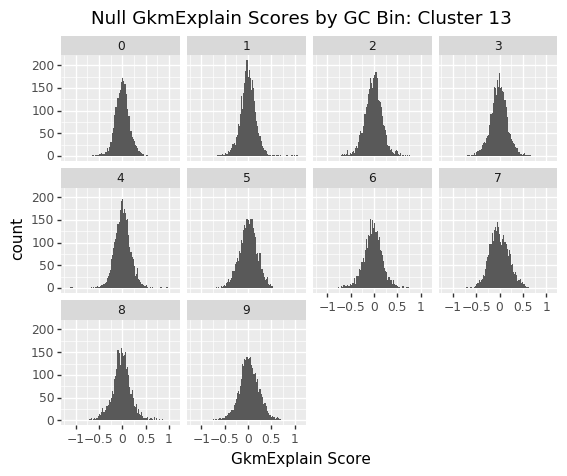

<ggplot: (-9223363293930842403)>

In [13]:
display(ggplot(data=null_scores, mapping=aes(x='null_explain_score'))
        + geom_histogram(bins=100)
        + labs(title='Null GkmExplain Scores by GC Bin: Cluster ' + cluster, x='GkmExplain Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null GkmExplain Scores

Fitted t Distribution: 

Mean: 	 -0.002216459922603823
Stdev: 	 0.16414671173705367

KstestResult(statistic=0.003316516032431216, pvalue=0.907208485335569)



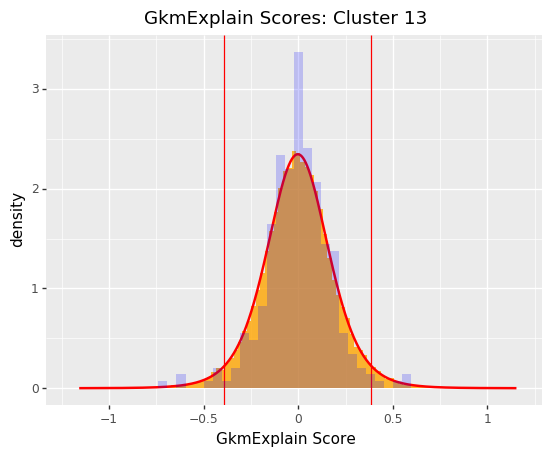

<ggplot: (8742893667276)>

In [14]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
explain_params = distrib.fit(merged_null_explain_scores)
x_explain = np.linspace(distrib.ppf(0.0001, *explain_params[:-2], explain_params[-2], explain_params[-1]),
                        distrib.ppf(0.9999, *explain_params[:-2], explain_params[-2], explain_params[-1]), 10000)
y_explain = distrib.pdf(x_explain, *explain_params[:-2], explain_params[-2], explain_params[-1])
distrib_explain = pd.DataFrame(list(zip(x_explain, y_explain)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', explain_params[-2])
print('Stdev:', '\t', explain_params[-1])
print()
print(kstest(merged_null_explain_scores, distrib_name, args=[*explain_params[:-2], explain_params[-2], explain_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_explain_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='GkmExplain Scores: Cluster ' + cluster, x='GkmExplain Score')
        + geom_line(data=distrib_explain, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *explain_params[:-2], explain_params[-2], explain_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *explain_params[:-2], explain_params[-2], explain_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='explain_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null ISM Score Distribution by GC Bin

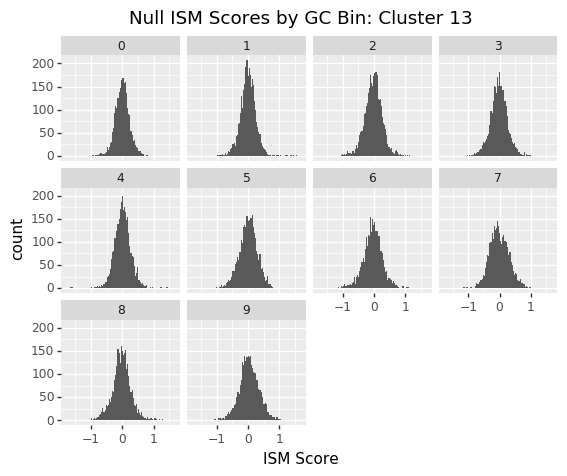

<ggplot: (-9223363293930835740)>

In [15]:
display(ggplot(data=null_scores, mapping=aes(x='null_ism_score'))
        + geom_histogram(bins=100)
        + labs(title='Null ISM Scores by GC Bin: Cluster ' + cluster, x='ISM Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null ISM Scores

Fitted t Distribution: 

Mean: 	 -0.003287016180028652
Stdev: 	 0.2444515984770091

KstestResult(statistic=0.0034058430557780683, pvalue=0.8896126632909058)



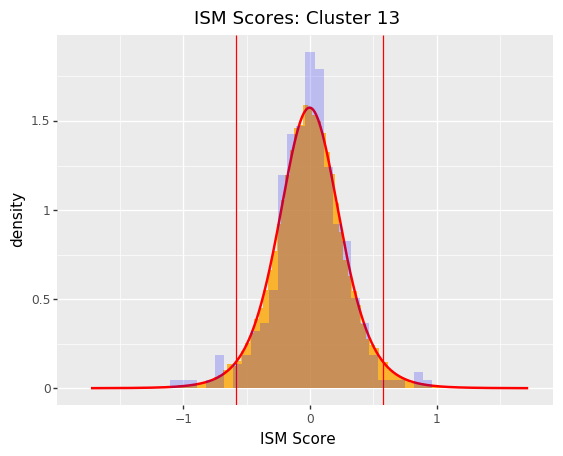

<ggplot: (8742893302234)>

In [16]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
ism_params = distrib.fit(merged_null_ism_scores)
x_ism = np.linspace(distrib.ppf(0.0001, *ism_params[:-2], ism_params[-2], ism_params[-1]),
                        distrib.ppf(0.9999, *ism_params[:-2], ism_params[-2], ism_params[-1]), 10000)
y_ism = distrib.pdf(x_ism, *ism_params[:-2], ism_params[-2], ism_params[-1])
distrib_ism = pd.DataFrame(list(zip(x_ism, y_ism)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', ism_params[-2])
print('Stdev:', '\t', ism_params[-1])
print()
print(kstest(merged_null_ism_scores, distrib_name, args=[*ism_params[:-2], ism_params[-2], ism_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_ism_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='ISM Scores: Cluster ' + cluster, x='ISM Score')
        + geom_line(data=distrib_ism, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *ism_params[:-2], ism_params[-2], ism_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *ism_params[:-2], ism_params[-2], ism_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='ism_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null deltaSVM Score Distribution by GC Bin

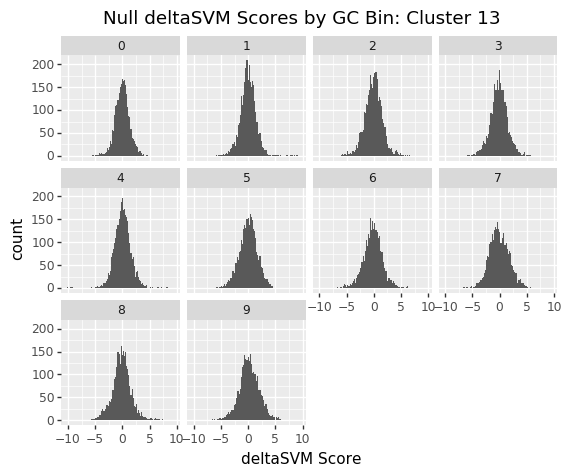

<ggplot: (-9223363293961443426)>

In [17]:
display(ggplot(data=null_scores, mapping=aes(x='null_delta_score'))
        + geom_histogram(bins=100)
        + labs(title='Null deltaSVM Scores by GC Bin: Cluster ' + cluster, x='deltaSVM Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null deltaSVM Scores

Fitted t Distribution: 

Mean: 	 -0.018967284253601904
Stdev: 	 1.4133798636884394

KstestResult(statistic=0.003615739504584159, pvalue=0.842782914495073)



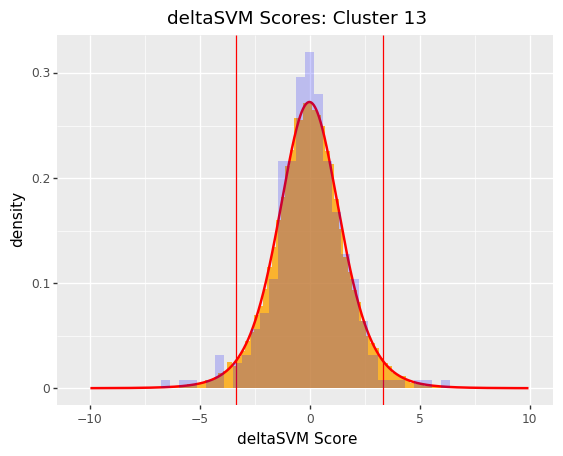

<ggplot: (-9223363293961835765)>

In [18]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
delta_params = distrib.fit(merged_null_delta_scores)
x_delta = np.linspace(distrib.ppf(0.0001, *delta_params[:-2], delta_params[-2], delta_params[-1]),
                        distrib.ppf(0.9999, *delta_params[:-2], delta_params[-2], delta_params[-1]), 10000)
y_delta = distrib.pdf(x_delta, *delta_params[:-2], delta_params[-2], delta_params[-1])
distrib_delta = pd.DataFrame(list(zip(x_delta, y_delta)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', delta_params[-2])
print('Stdev:', '\t', delta_params[-1])
print()
print(kstest(merged_null_delta_scores, distrib_name, args=[*delta_params[:-2], delta_params[-2], delta_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_delta_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='deltaSVM Scores: Cluster ' + cluster, x='deltaSVM Score')
        + geom_line(data=distrib_delta, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *delta_params[:-2], delta_params[-2], delta_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *delta_params[:-2], delta_params[-2], delta_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='delta_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Magnitude Score Distribution by GC Bin

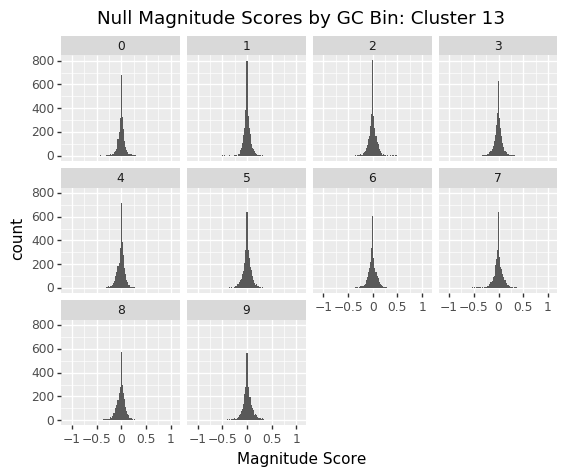

<ggplot: (-9223363293961802215)>

In [19]:
display(ggplot(data=null_scores, mapping=aes(x='null_magnitude_score'))
        + geom_histogram(bins=100)
        + labs(title='Null Magnitude Scores by GC Bin: Cluster ' + cluster, x='Magnitude Score')
        + facet_wrap("gc_bin"))

# Plot All Null Magnitude Scores

Fitted t Distribution: 

Mean: 	 -0.0005648909675852157
Stdev: 	 0.04892384274350335

KstestResult(statistic=0.04109262890471621, pvalue=5.843123278608592e-43)



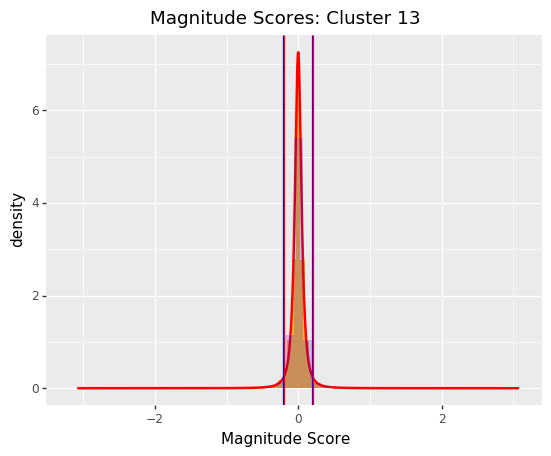

<ggplot: (8742894291790)>

In [20]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
magnitude_params = distrib.fit(null_confidence_dict['null_magnitude_score'])
x_magnitude = np.linspace(distrib.ppf(0.0001, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]),
                        distrib.ppf(0.9999, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]), 10000)
y_magnitude = distrib.pdf(x_magnitude, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])
distrib_magnitude = pd.DataFrame(list(zip(x_magnitude, y_magnitude)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', magnitude_params[-2])
print('Stdev:', '\t', magnitude_params[-1])
print()
print(kstest(null_confidence_dict['null_magnitude_score'], distrib_name, args=[*magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]]))
print()

null_magnitude_quantiles = list(null_scores['null_magnitude_score'].quantile([0.025, 0.975]))
display(ggplot(data=null_scores, mapping=aes(x='null_magnitude_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Magnitude Scores: Cluster ' + cluster, x='Magnitude Score')
        + geom_line(data=distrib_magnitude, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=null_magnitude_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_magnitude_quantiles[1]), color='blue')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='magnitude_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Prominence Score Distribution by GC Bin

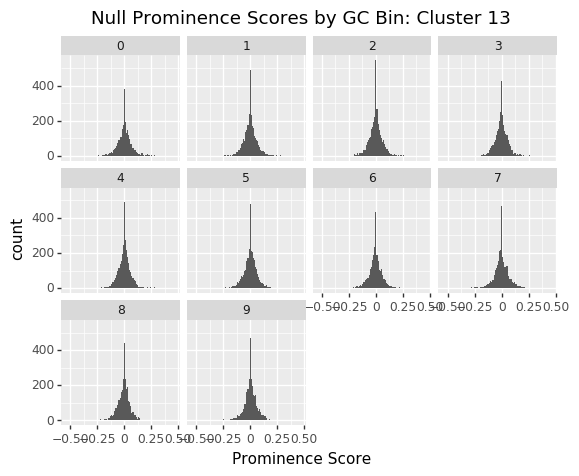

<ggplot: (8742894239934)>

In [21]:
display(ggplot(data=null_scores, mapping=aes(x='null_prominence_score'))
        + geom_histogram(bins=100)
        + labs(title='Null Prominence Scores by GC Bin: Cluster ' + cluster, x='Prominence Score')
        + facet_wrap("gc_bin"))

# Plot All Null Prominence Scores

Fitted t Distribution: 

Mean: 	 -0.0005028096042937779
Stdev: 	 0.04143217359867796

KstestResult(statistic=0.03677644883220066, pvalue=1.7085129927662234e-34)



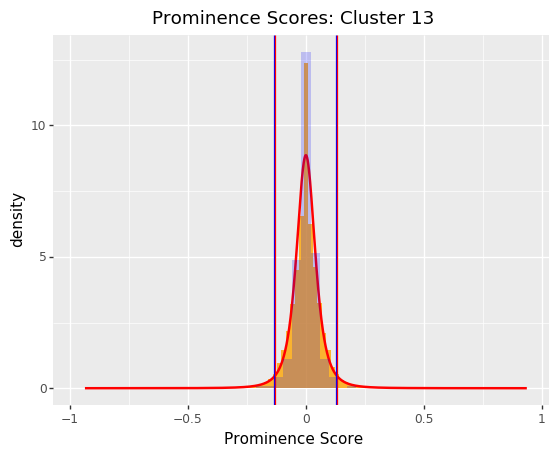

<ggplot: (8742892547669)>

In [22]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
prominence_params = distrib.fit(null_confidence_dict['null_prominence_score'])
x_prominence = np.linspace(distrib.ppf(0.0001, *prominence_params[:-2], prominence_params[-2], prominence_params[-1]),
                        distrib.ppf(0.9999, *prominence_params[:-2], prominence_params[-2], prominence_params[-1]), 10000)
y_prominence = distrib.pdf(x_prominence, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])
distrib_prominence = pd.DataFrame(list(zip(x_prominence, y_prominence)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', prominence_params[-2])
print('Stdev:', '\t', prominence_params[-1])
print()
print(kstest(null_confidence_dict['null_prominence_score'], distrib_name, args=[*prominence_params[:-2], prominence_params[-2], prominence_params[-1]]))
print()
null_prominence_quantiles = list(null_scores['null_prominence_score'].quantile([0.025, 0.975]))

display(ggplot(data=null_scores, mapping=aes(x='null_prominence_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Prominence Scores: Cluster ' + cluster, x='Prominence Score')
        + geom_line(data=distrib_prominence, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=null_prominence_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_prominence_quantiles[1]), color='blue')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='prominence_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Importance Scores

Fitted t Distribution: 

Mean: 	 0.0028462969250069798
Stdev: 	 0.00800569732634857



KstestResult(statistic=0.01658861456796129, pvalue=1.9092640189018328e-239)



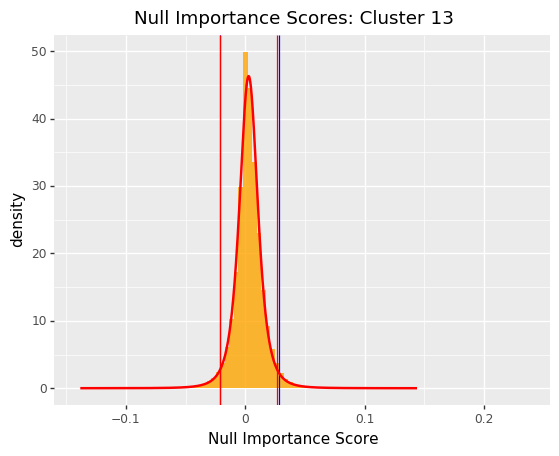

<ggplot: (8742892505913)>

In [23]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
sampled_null_importance_scores = random.sample(null_importance_scores, 1000000)
null_importance_df = pd.DataFrame(sampled_null_importance_scores, columns=['null_importance_score'])
importance_params = distrib.fit(sampled_null_importance_scores)
x_importance = np.linspace(distrib.ppf(0.0001, *importance_params[:-2], importance_params[-2], importance_params[-1]),
                           distrib.ppf(0.9999, *importance_params[:-2], importance_params[-2], importance_params[-1]), 10000)
y_importance = distrib.pdf(x_importance, *importance_params[:-2], importance_params[-2], importance_params[-1])
distrib_importance = pd.DataFrame(list(zip(x_importance, y_importance)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', importance_params[-2])
print('Stdev:', '\t', importance_params[-1])
print()
print(stats.kstest(sampled_null_importance_scores, distrib_name, args=[*importance_params[:-2], importance_params[-2], importance_params[-1]]))
print()
null_importance_quantiles = list(null_importance_df['null_importance_score'].quantile([0.025, 0.975]))

display(ggplot(data=null_importance_df, mapping=aes(x='null_importance_score'))       
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Null Importance Scores: Cluster ' + cluster, x='Null Importance Score')
        + geom_vline(mapping=aes(xintercept=null_importance_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_importance_quantiles[1]), color='blue')
        + geom_line(data=distrib_importance, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *importance_params[:-2], importance_params[-2], importance_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *importance_params[:-2], importance_params[-2], importance_params[-1])), color='red'))

# Get P-Values for SNP Scores <a name='calculate_pvals' />

In [24]:
snp_scores['explain_pval'] = [(2 * min(distrib.cdf(x, *explain_params[:-2], explain_params[-2], explain_params[-1]),
                                      1 - distrib.cdf(x, *explain_params[:-2], explain_params[-2], explain_params[-1]))) \
                              for x in snp_scores['explain_score']]
snp_scores['ism_pval'] = [(2 * min(distrib.cdf(x, *ism_params[:-2], ism_params[-2], ism_params[-1]),
                                  1 - distrib.cdf(x, *ism_params[:-2], ism_params[-2], ism_params[-1]))) \
                              for x in snp_scores['ism_score']]
snp_scores['delta_pval'] = [(2 * min(distrib.cdf(x, *delta_params[:-2], delta_params[-2], delta_params[-1]),
                                  1 - distrib.cdf(x, *delta_params[:-2], delta_params[-2], delta_params[-1]))) \
                              for x in snp_scores['delta_score']]
snp_scores['magnitude_pval'] = [(2 * min((percentileofscore(list(null_scores['null_magnitude_score']), x) / 100),
                                         (1 - (percentileofscore(list(null_scores['null_magnitude_score']), x) / 100)))) \
                                for x in snp_scores['magnitude_score']]
snp_scores['prominence_pval'] = [(2 * min((percentileofscore(list(null_scores['null_prominence_score']), x) / 100),
                                          (1 - (percentileofscore(list(null_scores['null_prominence_score']), x) / 100)))) \
                                 for x in snp_scores['prominence_score']]

confidence_values = []

for index, row in snp_scores.iterrows():
    confidence = -1
    if row['explain_pval'] < 0.05 and row['ism_pval'] < 0.05 and row['delta_pval'] < 0.05:
        confidence += 1
        if row['prominence_pval'] < 0.05:
            confidence += 2
        elif row['magnitude_pval'] < 0.05 or row['prominence_pval'] < 0.10:
            confidence += 1
    confidence_values.append(confidence)

snp_scores['confidence'] = confidence_values
snp_scores.sort_values(by=['prominence_pval', 'magnitude_pval', 'explain_pval'], inplace=True)
snp_scores.sort_values(by=['confidence'], ascending=False, inplace=True)
snp_scores.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_scores/overlap_snps/Cluster'
                       + cluster + '.' + celltype + '.updated.overlap.snp_scores.tsv', sep='\t', index=False)
idr_snp_scores = snp_scores.loc[snp_scores['in_idr_peak'] == True].copy()
idr_snp_scores.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_scores/idr_snps/Cluster'
                       + cluster + '.' + celltype + '.updated.idr.snp_scores.tsv', sep='\t', index=False)
sig_snps = snp_scores.loc[snp_scores['confidence'] >= 0].copy()
sig_snps = sig_snps.loc[sig_snps['effect'] != 'NA']
sig_snps = sig_snps.loc[sig_snps['noneffect'] != 'NA']
unique_sig_snps = sig_snps.sort_values(by=['rsid','prominence_pval'])
unique_sig_snps.drop_duplicates(subset=['rsid'], inplace=True)
unique_sig_snps.sort_values(by=['prominence_pval', 'magnitude_pval', 'explain_pval'], inplace=True)
unique_sig_snps.sort_values(by=['confidence'], ascending=False, inplace=True)
idr_unique_sig_snps = unique_sig_snps.loc[unique_sig_snps['in_idr_peak'] == True].copy()

print('Unique Significant SNPs:')
print()
display(idr_unique_sig_snps)
print()
print('Shape: ', idr_unique_sig_snps.shape)
print()
print('SNPs with Significant Scores:', '\t', '\t', '\t', len(idr_unique_sig_snps))
print('Significant SNPs with Low Confidence:', '\t', '\t', len(idr_unique_sig_snps.loc[idr_unique_sig_snps['confidence'] == 0]))
print('Significant SNPs with Moderate Confidence:', '\t', len(idr_unique_sig_snps.loc[idr_unique_sig_snps['confidence'] == 1]))
print('Significant SNPs with High Confidence:', '\t', '\t', len(idr_unique_sig_snps.loc[idr_unique_sig_snps['confidence'] == 2]))
print()
print('Total SNPs Scored: ', '\t', '\t', '\t', '\t', len(idr_snp_scores))
print('Unique SNPs Scored: ', '\t', '\t', '\t', '\t', len(idr_snp_scores.sort_values(by='rsid').drop_duplicates(subset='rsid')))

Unique Significant SNPs:



,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gc,explain_score,ism_score,delta_score,magnitude_score,prominence_score,gc_bin,gwas,gwas_pval,coloc,in_idr_peak,active_seqlet,inactive_seqlet,diff_seqlet,active_allele,explain_pval,ism_pval,delta_pval,magnitude_pval,prominence_pval,confidence
241,chr3,52498433,52498434,rs181391313,G,A,G,A,G,A,-,93,0.591,0.529233,0.827670,4.759423,0.299315,0.189151,6,Chang_23andMe_Parkinsons,2.730650e-03,False,True,GGCGGAG,GGCAGAG,GGC(G/A)GAG,effect,0.014225,0.011471,0.011692,0.015034,0.015655,2
64,chr17,4901871,4901872,rs79436576,T,C,C,T,C,T,+,55,0.622,-0.701655,-1.097551,-6.459804,-0.689061,-0.176676,7,Alzheimers_Lambert_2013,4.790000e-05,True,True,TTGGCCCCGCCCC,TTGGCCTCGCCCC,TTGGCC(C/T)CGCCCC,noneffect,0.003710,0.002886,0.002594,0.000690,0.021172,2
230,chr3,49007333,49007334,rs6781790,T,C,C,T,T,C,+,92,0.658,-0.606843,-0.955499,-5.535802,-0.477618,-0.161974,8,Nalls_23andMe,2.349340e-03,False,True,GAGGGCGCTGT,GAGGGTGCTGT,GAGGG(C/T)GCTGT,noneffect,0.007772,0.005946,0.005839,0.004276,0.028966,2
121,chr17,46771150,46771151,rs199523,C,A,C,A,A,C,-,54,0.693,0.405084,0.642397,3.709562,0.323587,0.120272,9,23andme_PD_hg38,9.490000e-14,True,True,CGCCACCTAC,AGCCACCTAC,(C/A)GCCACCTAC,effect,0.042004,0.033387,0.033428,0.011586,0.061586,1
155,chr19,44846144,44846145,rs3810143,T,C,T,"C,G",T,"C,G",-,71,0.689,0.416072,0.678068,3.917214,0.320356,0.086996,9,Alzheimers_Jansen_2018,5.980000e-50,True,True,TTCTTTGGCA,TTCTTCGGCA,TTCTT(T/C)GGCA,effect,0.038081,0.027040,0.027022,0.011862,0.136621,1
199,chr19,45326535,45326536,rs344791,C,G,G,C,C,G,-,71,0.543,-0.638326,-1.022222,-5.886347,-0.070105,-0.084164,4,Alzheimers_Jansen_2018,1.215671e-04,True,True,ACCGCCT,ACCCCCT,ACC(G/C)CCT,noneffect,0.006046,0.004207,0.004260,0.314414,0.157448,0
244,chr3,122416407,122416408,rs55911744,T,G,T,G,T,G,-,86,0.494,-0.437948,-0.686375,-3.988701,-0.063031,-0.032408,2,Nalls_23andMe,4.986370e-04,False,True,ACCGGAC,ACCTGAC,ACC(G/T)GAC,noneffect,0.032614,0.026766,0.026114,0.349793,0.486552,0
295,chr8,22604860,22604861,rs3735901,T,C,T,C,T,C,-,125,0.683,0.565717,0.879976,5.958786,0.020319,0.010934,9,Nalls_23andMe,5.081120e-02,False,True,CCCTGCC,CCCCGCC,CCC(T/C)GCC,effect,0.010486,0.008601,0.003865,0.656897,0.731862,0
106,chr17,45992473,45992474,rs17651887,G,A,G,A,G,A,+,54,0.510,-0.452784,-0.709871,-4.064543,-0.015207,-0.007482,3,23andme_PD_hg38,2.187050e-22,True,True,GAGAGTC,GAGGGTC,GAG(A/G)GTC,noneffect,0.028608,0.023325,0.024178,0.734414,0.807931,0
169,chr19,44915228,44915229,rs12691088,A,G,G,"A,C",G,"A,C",+,71,0.583,0.551240,0.922351,5.310119,0.007221,0.003777,5,Alzheimers_Kunkle_2019,2.690000e-238,True,True,GGTAGGG,GGTGGGG,GGT(A/G)GGG,effect,0.011825,0.006846,0.006940,0.807517,0.851310,0



Shape:  (11, 33)

SNPs with Significant Scores: 	 	 	 11
Significant SNPs with Low Confidence: 	 	 6
Significant SNPs with Moderate Confidence: 	 2
Significant SNPs with High Confidence: 	 	 3

Total SNPs Scored:  	 	 	 	 293
Unique SNPs Scored:  	 	 	 	 265


# Visualize High Confidence SNPs <a name='visualize_high_conf' />


Index: 241

RSID: rs181391313 	 	 || 	 chr3 : 52498433 - 52498434 	 || 	 Locus: 93

GWAS: Chang_23andMe_Parkinsons 	 || 	 GWAS P-Value: 2.7306E-03 	 || 	 Coloc: False

Prominence P-Value: 1.5655E-02 	 || 	 Magnitude P-Value: 1.5034E-02 	 || 	 Confidence: 2

GkmExplain P-Value: 1.4225E-02 	 || 	 ISM P-Value: 1.1471E-02 	 || 	 deltaSVM P-Value: 1.1692E-02

----------------------------------------------------------------------------------------------------

Effect Allele: G 	 	 || 	 Active Seqlet: GGCGGAG



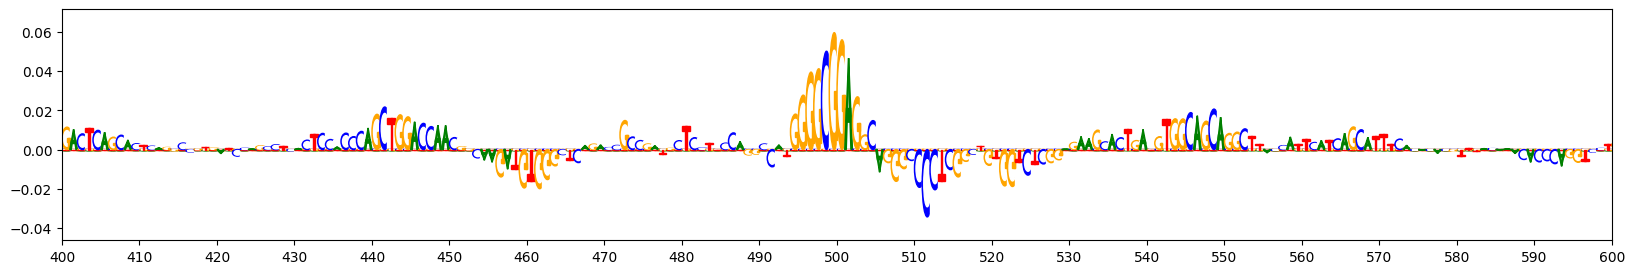


Non-Effect Allele: A 	 	 || 	 Inactive Seqlet: GGCAGAG



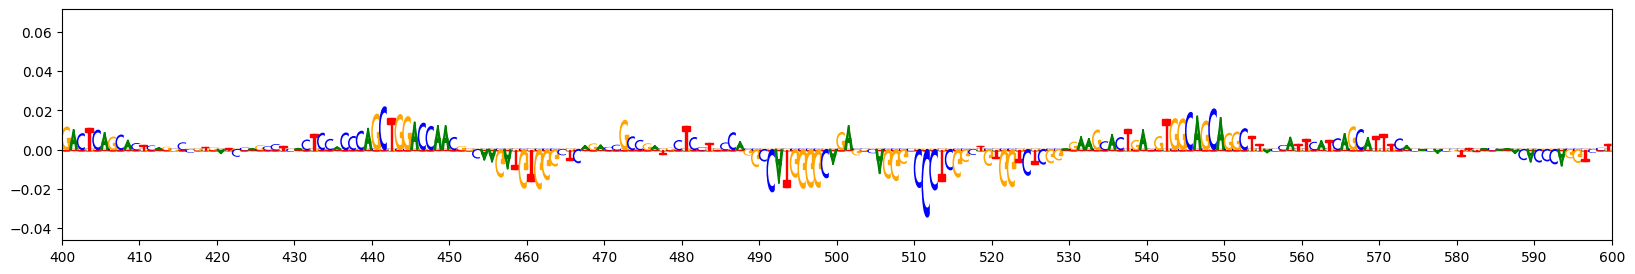


Difference Seqlet: GGC(G/A)GAG



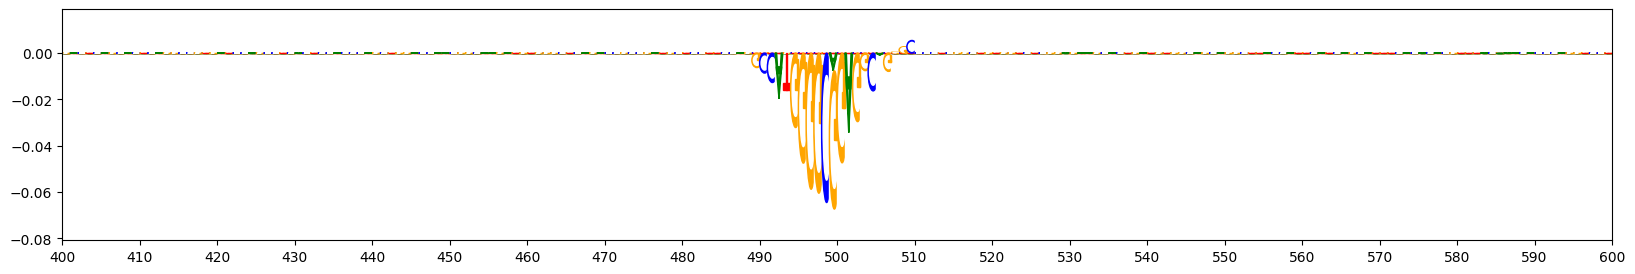


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 64

RSID: rs79436576 	 	 || 	 chr17 : 4901871 - 4901872 	 || 	 Locus: 55

GWAS: Alzheimers_Lambert_2013 	 || 	 GWAS P-Value: 4.7900E-05 	 || 	 Coloc: True

Prominence P-Value: 2.1172E-02 	 || 	 Magnitude P-Value: 6.8966E-04 	 || 	 Confidence: 2

GkmExplain P-Value: 3.7096E-03 	 || 	 ISM P-Value: 2.8856E-03 	 || 	 deltaSVM P-Value: 2.5940E-03

----------------------------------------------------------------------------------------------------

Non-Effect Allele: C 	 	 || 	 Active Seqlet: TTGGCCCCGCCCC



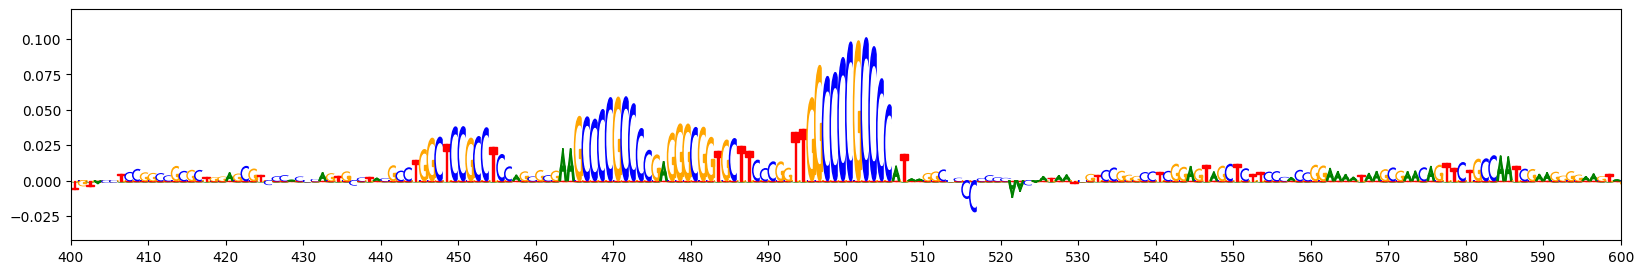


Effect Allele: T 	 	 || 	 Inactive Seqlet: TTGGCCTCGCCCC



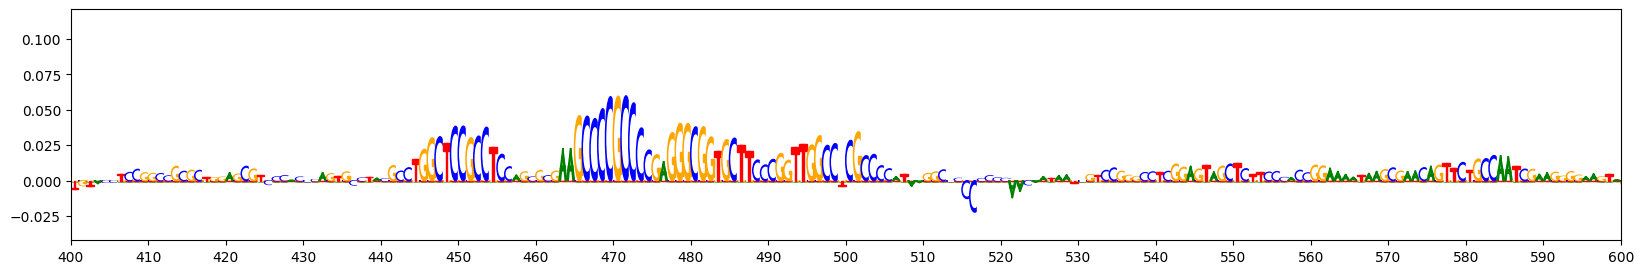


Difference Seqlet: TTGGCC(C/T)CGCCCC



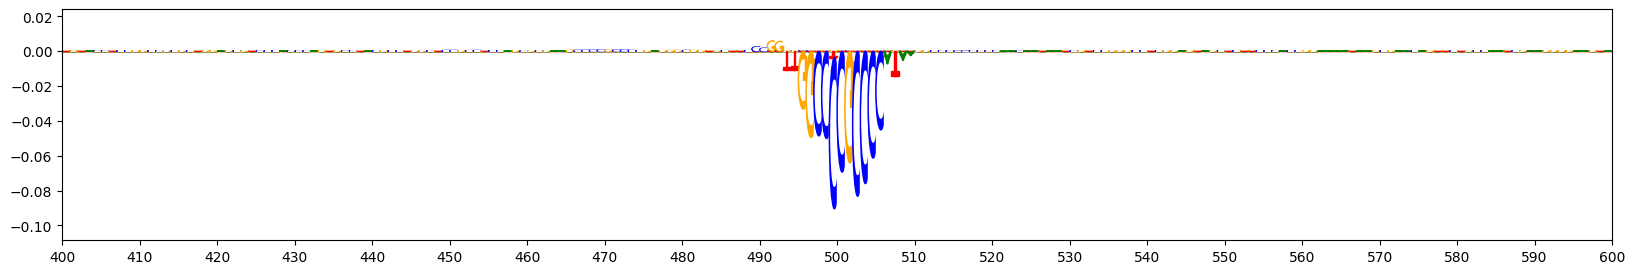


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 230

RSID: rs6781790 	 	 || 	 chr3 : 49007333 - 49007334 	 || 	 Locus: 92

GWAS: Nalls_23andMe 	 || 	 GWAS P-Value: 2.3493E-03 	 || 	 Coloc: False

Prominence P-Value: 2.8966E-02 	 || 	 Magnitude P-Value: 4.2759E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 7.7719E-03 	 || 	 ISM P-Value: 5.9460E-03 	 || 	 deltaSVM P-Value: 5.8391E-03

----------------------------------------------------------------------------------------------------

Non-Effect Allele: C 	 	 || 	 Active Seqlet: GAGGGCGCTGT



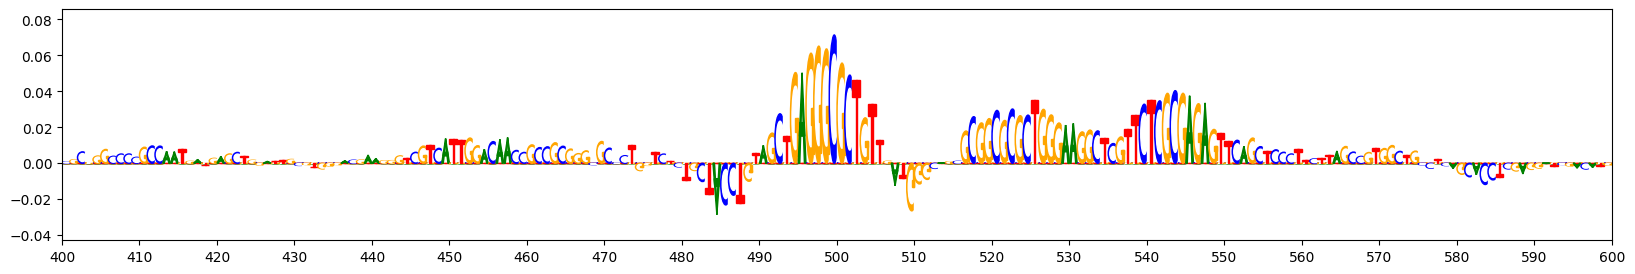


Effect Allele: T 	 	 || 	 Inactive Seqlet: GAGGGTGCTGT



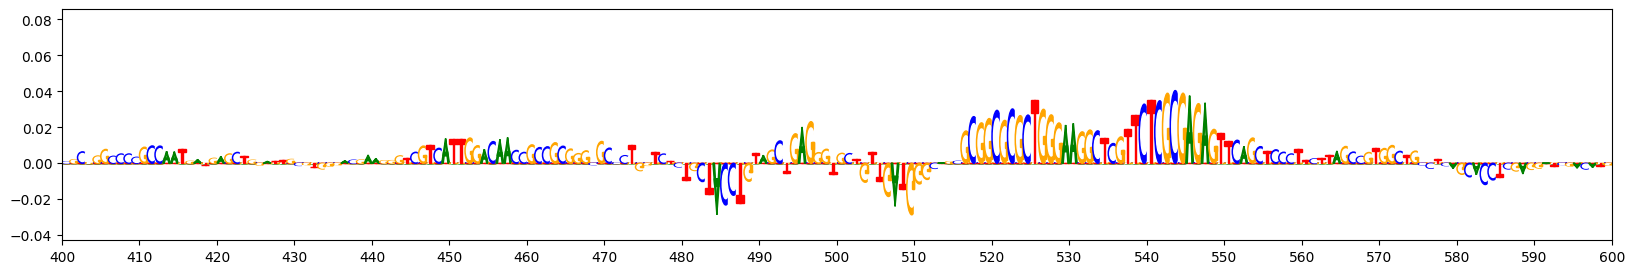


Difference Seqlet: GAGGG(C/T)GCTGT



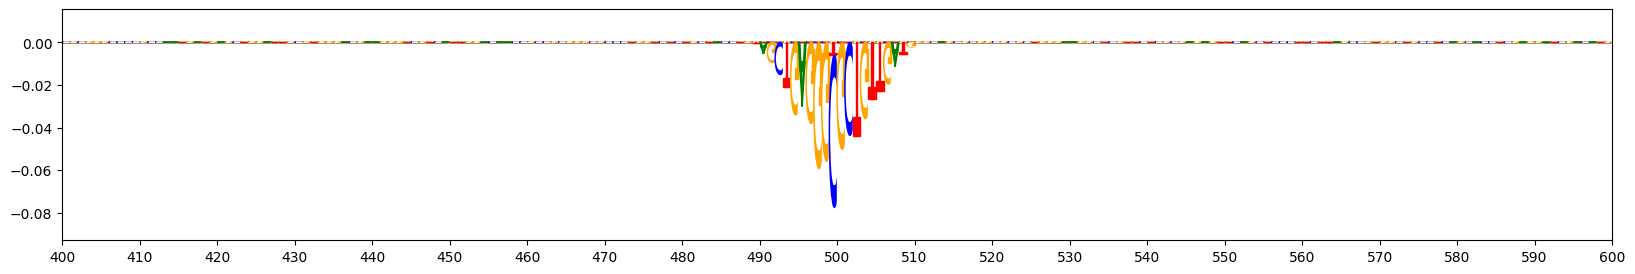


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



In [25]:
for index,row in idr_unique_sig_snps.loc[idr_unique_sig_snps['confidence'] == 2].iterrows():
    print()
    print('Index:', index)
    print()
    print('RSID:', row['rsid'],
          '\t', '\t', '||', '\t',
          row['chr'], ':', row['start'], '-', row['end'],
          '\t', '||', '\t',
          'Locus:', row['locus_num'])
    print()
    print('GWAS:', row['gwas'],
          '\t', '||', '\t',
          'GWAS P-Value:', '%.4E' % Decimal(row['gwas_pval']),
          '\t', '||', '\t',
          'Coloc:', row['coloc'])
    print()
    print('Prominence P-Value:', '%.4E' % Decimal(row['prominence_pval']),
          '\t', '||', '\t',
          'Magnitude P-Value:', '%.4E' % Decimal(row['magnitude_pval']),
          '\t', '||', '\t',
          'Confidence:', row['confidence'])
    print()
    print('GkmExplain P-Value:', '%.4E' % Decimal(row['explain_pval']),
          '\t', '||', '\t',
          'ISM P-Value:', '%.4E' % Decimal(row['ism_pval']),
          '\t', '||', '\t',
          'deltaSVM P-Value:', '%.4E' % Decimal(row['delta_pval']))    
    print()
    print('-'*100)
    print()
    
    #--------------------------------------#
    
    if row['active_allele'] == 'effect':
        if row['effect'] != 'NA':
            print('Effect Allele:', row['effect'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        else:
            print('Minor Allele:', row['minor'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        print()
        ylim = plot_weights(merged_observed_effect_scores[index],
                            subticks_frequency=10, xlim=(400,600))
        print()
    else:
        if row['noneffect'] != 'NA':
            print('Non-Effect Allele:', row['noneffect'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        else:
            print('Major Allele:', row['major'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        print()
        ylim = plot_weights(merged_observed_noneffect_scores[index],
                            subticks_frequency=10, xlim=(400,600))
        print()
        
    #--------------------------------------#
        
    if row['active_allele'] != 'effect':
        if row['effect'] != 'NA':
            print('Effect Allele:', row['effect'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        else:
            print('Minor Allele:', row['minor'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        print()
        a = plot_weights(merged_observed_effect_scores[index],
                         subticks_frequency=10, ylim=ylim, xlim=(400,600))
        print()
    else:
        if row['noneffect'] != 'NA':
            print('Non-Effect Allele:', row['noneffect'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        else:
            print('Major Allele:', row['major'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        print()
        a = plot_weights(merged_observed_noneffect_scores[index],
                         subticks_frequency=10, ylim=ylim, xlim=(400,600))
        print()
    
    #--------------------------------------#
    
    print('Difference Seqlet:', row['diff_seqlet'])
    print()
    if row['active_allele'] == 'effect':
        a = plot_weights(merged_observed_noneffect_scores[index] - merged_observed_effect_scores[index],
                         subticks_frequency=10, xlim=(400,600))
    else:
        a = plot_weights(merged_observed_effect_scores[index] - merged_observed_noneffect_scores[index],
                         subticks_frequency=10, xlim=(400,600))
    print()
    print('-'*100)
    print('-'*100)
    print()

## Generate Signal Tracks

In [26]:
fc_tracks = []
pval_tracks = []

for index, row in idr_unique_sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/updated_snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/updated_snp_pval_signal_tracks/'+rsid+'.pval.png')
        
idr_unique_sig_snps['fc_track'] = fc_tracks
idr_unique_sig_snps['pval_track'] = pval_tracks

/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


/bin/sh: 1: pyGenomeTracks: not found


# Final Significant SNPs Table <a name='prep_final_table' />

In [27]:
final_sig_snps = idr_unique_sig_snps[['chr', 'start', 'end', 'rsid',
                                  'effect', 'noneffect', 'major', 'minor', 'direction',
                                  'locus_num', 'gwas', 'gwas_pval', 'coloc', 'in_idr_peak',
                                  'explain_pval', 'ism_pval', 'delta_pval',
                                  'magnitude_pval', 'prominence_pval', 'confidence',
                                  'active_seqlet', 'diff_seqlet', 'active_allele',
                                  'fc_track', 'pval_track']]

final_sig_snps.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_sig_snps/Cluster'
                       + cluster + '.' + celltype + '.updated.idr.unique.sig_snps.tsv', sep='\t', index=False)
print('Final Significant SNPs Table:')
print()
display(final_sig_snps)
print()
print('Shape: ', final_sig_snps.shape)

Final Significant SNPs Table:



,chr,start,end,rsid,effect,noneffect,major,minor,direction,locus_num,gwas,gwas_pval,coloc,in_idr_peak,explain_pval,ism_pval,delta_pval,magnitude_pval,prominence_pval,confidence,active_seqlet,diff_seqlet,active_allele,fc_track,pval_track
241,chr3,52498433,52498434,rs181391313,G,A,G,A,-,93,Chang_23andMe_Parkinsons,2.730650e-03,False,True,0.014225,0.011471,0.011692,0.015034,0.015655,2,GGCGGAG,GGC(G/A)GAG,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
64,chr17,4901871,4901872,rs79436576,T,C,C,T,+,55,Alzheimers_Lambert_2013,4.790000e-05,True,True,0.003710,0.002886,0.002594,0.000690,0.021172,2,TTGGCCCCGCCCC,TTGGCC(C/T)CGCCCC,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
230,chr3,49007333,49007334,rs6781790,T,C,T,C,+,92,Nalls_23andMe,2.349340e-03,False,True,0.007772,0.005946,0.005839,0.004276,0.028966,2,GAGGGCGCTGT,GAGGG(C/T)GCTGT,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
121,chr17,46771150,46771151,rs199523,C,A,A,C,-,54,23andme_PD_hg38,9.490000e-14,True,True,0.042004,0.033387,0.033428,0.011586,0.061586,1,CGCCACCTAC,(C/A)GCCACCTAC,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
155,chr19,44846144,44846145,rs3810143,T,C,T,"C,G",-,71,Alzheimers_Jansen_2018,5.980000e-50,True,True,0.038081,0.027040,0.027022,0.011862,0.136621,1,TTCTTTGGCA,TTCTT(T/C)GGCA,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
199,chr19,45326535,45326536,rs344791,C,G,C,G,-,71,Alzheimers_Jansen_2018,1.215671e-04,True,True,0.006046,0.004207,0.004260,0.314414,0.157448,0,ACCGCCT,ACC(G/C)CCT,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
244,chr3,122416407,122416408,rs55911744,T,G,T,G,-,86,Nalls_23andMe,4.986370e-04,False,True,0.032614,0.026766,0.026114,0.349793,0.486552,0,ACCGGAC,ACC(G/T)GAC,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
295,chr8,22604860,22604861,rs3735901,T,C,T,C,-,125,Nalls_23andMe,5.081120e-02,False,True,0.010486,0.008601,0.003865,0.656897,0.731862,0,CCCTGCC,CCC(T/C)GCC,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
106,chr17,45992473,45992474,rs17651887,G,A,G,A,+,54,23andme_PD_hg38,2.187050e-22,True,True,0.028608,0.023325,0.024178,0.734414,0.807931,0,GAGAGTC,GAG(A/G)GTC,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
169,chr19,44915228,44915229,rs12691088,A,G,G,"A,C",+,71,Alzheimers_Kunkle_2019,2.690000e-238,True,True,0.011825,0.006846,0.006940,0.807517,0.851310,0,GGTAGGG,GGT(A/G)GGG,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...



Shape:  (11, 25)
